# AutoML Predictive models for clinical significance / PI-RADS

We will be exploring the use of radiomics for predicting the clinical significance of prostate lesions on mpMRI images.

Our data consists of mpMRI images and annotations prepared by three radiologists, as well as clinical information and biopsy results with International Society of Urological Pathology (ISUP) Gleason grading for each lesion. The radiologists annotated the data with multiple imaging features for each lesion, using the assessment algorithm from the PI-RADS standard.

To verify the hypotheses, we will be using a supervised learning algorithm to train a model on the mpMRI images and the biopsy results. We use extracted radiomics features and use cross-validation to assess the performance of the model, and visualize the results using a receiver operating characteristic (ROC) curve.

Interesting targets:

Clinical Significance
'TBx'

PI-RADS values:
'lesion_t2w_pz',
'lesion_t2w_tz', 
'lesion_dwi', 
'lesion_dce', 
'lesion_pirads',
'patient_pirads', 
'lesion_t2w_pz_cat', 
'lesion_t2w_tz_cat',
'lesion_dwi_cat'



Let's begin by importing the necessary libraries and loading the data.

In [1]:
#!pip install --no-cache-dir pycaret

In [2]:
import ai4ar # AI4AR Helper package

import pandas as pd # For saving the features
from pycaret.classification import *


import sys 
import os 
from config import config # For reading the config files

In [3]:
# Setup the notebook
%load_ext autoreload
%autoreload 2

# Add src to path

if os.path.basename(os.getcwd()) != 'ai4ar-radiomics':
    os.chdir('..')

if 'src' not in sys.path:
    sys.path.append('src')

cfg = config(
    ('json', 'config/config.json', True),
    ('json', 'config/config-ext.json', True),
    ignore_missing_paths = True
)

In [4]:
# Load the dataset
dataset = ai4ar.Dataset(cfg['data_dir'])

# Add T2W pirads category
dataset.radiological_metadata['lesion_t2w_cat'] = dataset.radiological_metadata['lesion_t2w_pz_cat'].fillna('') + dataset.radiological_metadata['lesion_t2w_tz_cat'].fillna('')
dataset.radiological_metadata['lesion_t2w'] = dataset.radiological_metadata['lesion_t2w_pz'].fillna(0) + dataset.radiological_metadata['lesion_t2w_tz'].fillna(0)

# Load the extracted radiomics features
t2w_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_t2w.csv'))
# Load the extracted radiomics features
adc_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_adc.csv'))
# Load the extracted radiomics features
hbv_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_hbv.csv'))
# Load the extracted radiomics features
dce_features = pd.read_csv(os.path.join('.',dataset.tmp_dir, 'radiomics_dce3.csv'))

# IDX columns
idx_cols = ['patient_id', 'lesion_id', 'radiologist_id']

In [5]:

dataset.radiological_metadata.head(5)

,patient_id,radiologist_id,lesion_id,TBx,dimension,lesion_dim_sequence,lesion_sectors,lesion_sectors_simple,lesion_zones,lesion_originating,lesion_side,lesion_t2w_pz,lesion_t2w_tz,lesion_dwi,lesion_dce,lesion_pirads,patient_pirads,lesion_t2w_pz_cat,lesion_t2w_tz_cat,lesion_dwi_cat,label_adc,label_cor,label_hbv,label_sag,label_t2w,label_dce1,label_dce2,label_dce3,label_dce4,label_dce5,label_dce6,lesion_t2w_cat,lesion_t2w
0,1,U_OjmNZ8,1,0,16.0,T2W,"AS-left-in-mid,TZa-left-in-mid","AS,TZa","AS,TZ",TZ,LEFT,NaN,5.0,5.0,0.0,5.0,5.0,NaN,5b,5a,lesion_labels/lesion1/adc/OjmNZ8,NaN,lesion_labels/lesion1/hbv/OjmNZ8,NaN,lesion_labels/lesion1/t2w/OjmNZ8,NaN,NaN,NaN,NaN,NaN,NaN,5b,5.0
1,1,U_8ZmM76,1,0,29.0,T2W,"AS-right-in-base,TZa-right-in-base,AS-left-in-...","AS,TZa","AS,TZ",TZ,RIGHT LEFT,NaN,5.0,5.0,0.0,5.0,5.0,NaN,5a,5a,lesion_labels/lesion1/adc/8ZmM76,NaN,lesion_labels/lesion1/hbv/8ZmM76,NaN,lesion_labels/lesion1/t2w/8ZmM76,NaN,NaN,NaN,NaN,NaN,NaN,5a,5.0
2,1,U_OrjnrO,1,0,31.0,T2W,"AS-left-in-apex,AS-left-in-mid,AS-right-in-mid...",AS,AS,TZ,LEFT RIGHT,NaN,5.0,5.0,0.0,5.0,5.0,NaN,5b,5a,lesion_labels/lesion1/adc/OrjnrO,NaN,lesion_labels/lesion1/hbv/OrjnrO,NaN,lesion_labels/lesion1/t2w/OrjnrO,NaN,NaN,lesion_labels/lesion1/dce3/OrjnrO,NaN,NaN,NaN,5b,5.0
3,3,U_8ekGLQ,1,1,18.0,ADC,"AS-left-in-base,TZa-left-in-base,TZa-left-in-mid","AS,TZa","AS,TZ",TZ,LEFT,NaN,5.0,5.0,1.0,5.0,5.0,NaN,5a,5a,lesion_labels/lesion1/adc/8ekGLQ,NaN,lesion_labels/lesion1/hbv/8ekGLQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a,5.0
4,3,U_OjmNZ8,1,1,15.0,ADC,"TZa-left-in-base,TZa-left-in-mid,AS-left-in-base","TZa,AS","TZ,AS",TZ,LEFT,NaN,5.0,5.0,1.0,5.0,5.0,NaN,5a,5a,lesion_labels/lesion1/adc/OjmNZ8,NaN,lesion_labels/lesion1/hbv/OjmNZ8,NaN,NaN,NaN,NaN,lesion_labels/lesion1/dce3/OjmNZ8,NaN,NaN,NaN,5a,5.0


In [6]:
dataset.radiological_metadata.columns

Index(['patient_id', 'radiologist_id', 'lesion_id', 'TBx', 'dimension',
       'lesion_dim_sequence', 'lesion_sectors', 'lesion_sectors_simple',
       'lesion_zones', 'lesion_originating', 'lesion_side', 'lesion_t2w_pz',
       'lesion_t2w_tz', 'lesion_dwi', 'lesion_dce', 'lesion_pirads',
       'patient_pirads', 'lesion_t2w_pz_cat', 'lesion_t2w_tz_cat',
       'lesion_dwi_cat', 'label_adc', 'label_cor', 'label_hbv', 'label_sag',
       'label_t2w', 'label_dce1', 'label_dce2', 'label_dce3', 'label_dce4',
       'label_dce5', 'label_dce6', 'lesion_t2w_cat', 'lesion_t2w'],
      dtype='object')

In [7]:
t2w_features.head()

,patient_id,lesion_id,radiologist_id,mask_path,data_path,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares
0,1,1,U_OjmNZ8,lesion_labels/lesion1/t2w/OjmNZ8,data/t2w,95.0,159.0,3410783.0,2.248859,32.00,5.322890,227.0,21.785000,127.145000,127.5,6.0,221.0,14.030864,130.590639,-0.370589,1.082524e+07,0.264900,888.063975,32.293005,35.776776,-0.187163,2.797860,2.351875,0.086186,1.079460,1.904280,1.179326,0.609136,0.574963,0.978653,0.910431,-0.084887,0.549885,0.475830,5.672836,0.084822,4.116675,0.442936,0.147789,11.345671,2.699190,1.287434
1,1,1,U_8ZmM76,lesion_labels/lesion1/t2w/8ZmM76,data/t2w,83.0,161.0,18951780.0,2.436913,40.00,4.546336,270.0,25.262647,123.428818,126.0,0.0,270.0,16.605125,127.874305,-0.617128,6.014969e+07,0.226218,1117.164692,30.837574,48.771239,-2.971511,3.474053,2.993997,0.074468,1.300342,2.058430,1.289160,0.552497,0.504604,0.977182,0.901438,-0.033446,0.374144,0.468826,5.542182,0.060359,4.592517,0.239668,0.117783,11.084365,2.883047,1.617012
2,1,1,U_OrjnrO,lesion_labels/lesion1/t2w/OrjnrO,data/t2w,79.0,164.1,28481031.0,2.572456,44.00,4.571548,305.0,27.464452,123.463372,125.0,0.0,305.0,18.182307,128.680764,-0.125049,9.039389e+07,0.206492,1315.534705,30.357475,55.068221,-1.437511,3.881512,3.703067,0.025536,1.453161,2.182675,1.572226,0.526755,0.471751,0.979695,0.905787,-0.024875,0.331395,0.448691,5.505017,0.049960,4.861650,0.202465,0.104634,11.010035,2.987150,1.896145
3,3,1,U_8ZmM76,lesion_labels/lesion1/t2w/8ZmM76,data/t2w,63.0,201.0,2243638.0,3.056317,57.00,3.340976,286.0,41.261253,125.123967,115.0,8.0,278.0,27.283027,136.170712,0.634257,4.263823e+06,0.148009,2886.455707,29.189453,299.306654,16.623860,9.016457,7.338745,0.100625,2.086850,2.551521,2.949324,0.448228,0.373827,0.955844,0.863637,-0.158844,0.778955,0.369224,5.363399,0.030463,5.458917,0.482515,0.074127,10.726799,3.440320,4.088800
4,3,2,U_8ekGLQ,lesion_labels/lesion2/t2w/8ekGLQ,data/t2w,26.0,153.9,5056339.0,2.897668,67.75,2.874104,289.0,38.450543,90.657676,93.0,0.0,289.0,27.531955,102.422311,0.111455,9.609097e+06,0.146270,2271.515595,16.689695,131.985389,1.423610,7.115450,7.866815,-0.018507,2.245563,2.542368,2.533083,0.419999,0.337045,0.951980,0.853524,-0.084616,0.589371,0.340918,4.101640,0.025578,5.515494,0.359564,0.050298,8.203280,3.370117,3.745566


## DCE - PIRADS


Predicting the DCE PI-RADS score (+/-) based on the DCE radiomic features

In [8]:
target = 'lesion_dce'

radiomic_cols = [ col for col in dce_features.columns if 'original_' in col]
train = dataset.radiological_metadata.merge(dce_features, on=idx_cols, how='left')[[*radiomic_cols, target]]

# Filter na 
train = train[~train[target].isin(['na','x','X'])]
train = train[~train[target].isna()]
train[target] = train[target].astype(int)

In [9]:
len(train)

1105

In [10]:
clf1 = setup(
      data = train, 
      target = target,
      session_id=1229,
      normalize=True,
      transformation=True,
      ignore_low_variance=True,
      feature_selection=True,
      remove_multicollinearity=True, 
      silent=True,  # Otherwise it will ask for input
      multicollinearity_threshold=0.95
)

,Description,Value
0,session_id,1229
1,Target,lesion_dce
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1105, 43)"
5,Missing Values,True
6,Numeric Features,42
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Removed features

In [11]:
pd.DataFrame(set(train.columns)-set(get_config('X_train').columns)).T


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,original_glcm_SumEntropy,original_glcm_Autocorrelation,lesion_dce,original_firstorder_Energy,original_firstorder_Uniformity,original_glcm_DifferenceAverage,original_glcm_Imc2,original_glcm_MaximumProbability,original_glcm_SumAverage,original_firstorder_Mean,...,original_glcm_MCC,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Median,original_glcm_ClusterTendency,original_glcm_SumSquares,original_glcm_Idn,original_glcm_DifferenceVariance,original_glcm_Idm,original_firstorder_RootMeanSquared


Selected features

In [12]:
pd.DataFrame(set(get_config('X_train').columns)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,original_firstorder_Minimum,original_firstorder_Maximum,original_firstorder_10Percentile,original_glcm_Contrast,original_glcm_ClusterShade,original_firstorder_Range,original_glcm_Correlation,original_glcm_JointEnergy,original_firstorder_Kurtosis,original_firstorder_TotalEnergy,original_glcm_Idmn,original_firstorder_Skewness,original_glcm_JointAverage,original_glcm_InverseVariance,original_glcm_ClusterProminence,original_firstorder_90Percentile,original_glcm_Imc1


AutoML best model

In [13]:
top3 = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8811,0.8597,0.9275,0.9156,0.9211,0.6784,0.6809,0.0300
et,Extra Trees Classifier,0.8797,0.8709,0.9257,0.9155,0.9202,0.6751,0.6773,0.1690
rf,Random Forest Classifier,0.8784,0.8626,0.9275,0.9125,0.9196,0.6698,0.6722,0.1870
knn,K Neighbors Classifier,0.8733,0.8368,0.9154,0.9161,0.9155,0.6618,0.6635,0.0500
ada,Ada Boost Classifier,0.8681,0.8615,0.9067,0.9173,0.9115,0.6515,0.6540,0.0310
gbc,Gradient Boosting Classifier,0.8668,0.8563,0.9102,0.9126,0.9109,0.6460,0.6485,0.0550
ridge,Ridge Classifier,0.8604,0.0000,0.9084,0.9060,0.9068,0.6271,0.6290,0.0040
lr,Logistic Regression,0.8603,0.8432,0.9015,0.9117,0.9062,0.6318,0.6340,0.4720
qda,Quadratic Discriminant Analysis,0.8552,0.8367,0.8964,0.9097,0.9024,0.6201,0.6229,0.0050
lda,Linear Discriminant Analysis,0.8539,0.8238,0.8998,0.9052,0.9020,0.6135,0.6160,0.0040


In [14]:
tuned_top3 = [tune_model(i) for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8718,0.8517,0.9138,0.9138,0.9138,0.6638,0.6638
1,0.8462,0.8082,0.9483,0.8594,0.9016,0.5526,0.5670
2,0.8846,0.8853,0.8966,0.9455,0.9204,0.7116,0.7149
3,0.8701,0.8829,0.9310,0.9000,0.9153,0.6378,0.6395
4,0.9091,0.8916,0.9483,0.9322,0.9402,0.7510,0.7515
5,0.9221,0.9664,0.9655,0.9333,0.9492,0.7827,0.7848
6,0.8961,0.8348,0.9483,0.9167,0.9322,0.7103,0.7121
7,0.8571,0.8299,0.9138,0.8983,0.9060,0.6088,0.6092
8,0.8831,0.8525,0.9138,0.9298,0.9217,0.6910,0.6914


In [15]:
#blender = blend_models(tuned_top3)
#stacker = stack_models(tuned_top3) 

In [16]:
best_model = automl(optimize='AUC')

In [17]:
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=1229, verbose=0,
                     warm_start=False)

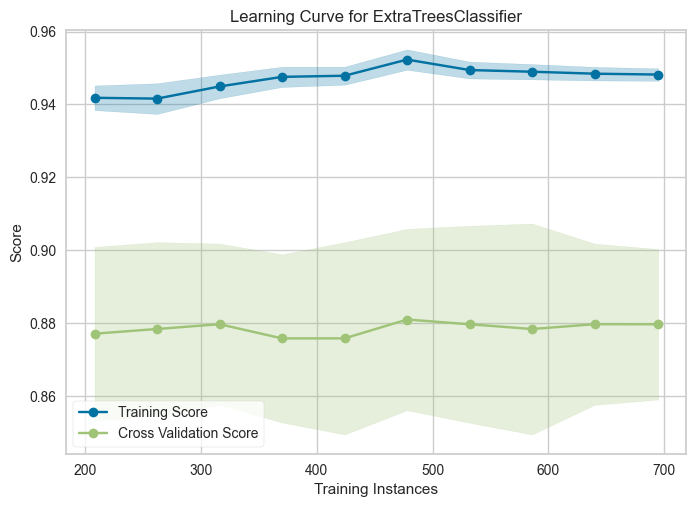

In [18]:
plot_model(best_model, plot = 'learning')

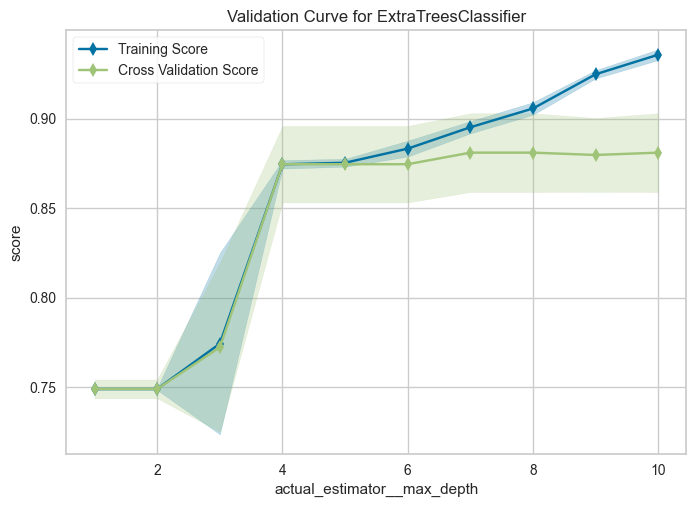

In [19]:
plot_model(best_model, plot = 'vc')

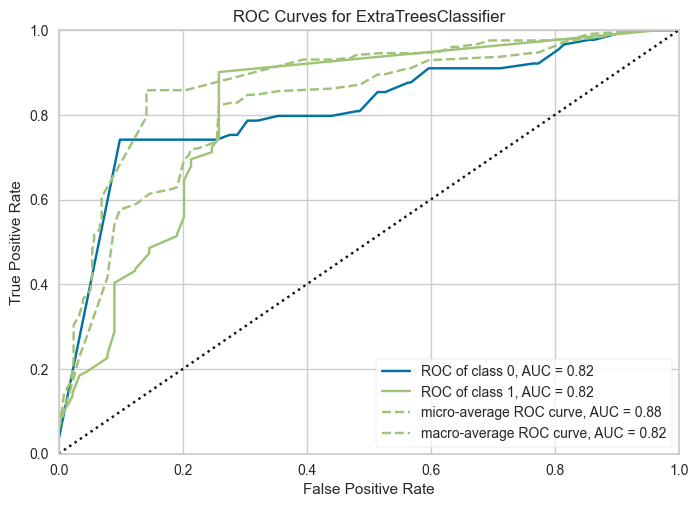

In [20]:
plot_model(best_model, plot = 'auc')

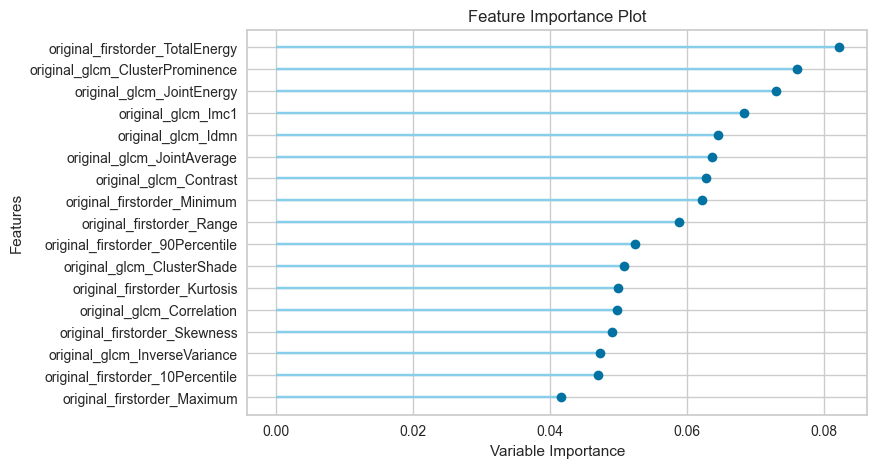

In [21]:
try: 
    plot_model(best_model, plot = 'feature_all')
except:
    print('No feature importance plot available')

## DWI (HBV) / ADC - PIRADS

Predicting the DWI/ADC PI-RADS score (0-5) based on the DWI and ADC radiomic features

In [22]:
target = 'lesion_dwi'


radiomic_dwi = hbv_features.merge(adc_features, on=idx_cols, how='left', suffixes=('_hbv', '_adc'))
radiomic_dwi_cols = [ col for col in radiomic_dwi.columns if 'original_' in col]

train = dataset.radiological_metadata.merge(radiomic_dwi, on=idx_cols, how='left')[[*radiomic_dwi_cols, target]]

# Filter na 
train = train[~train[target].isin(['na','x','X'])]
train = train[~train[target].isna()]
train[target] = train[target].astype(int)

In [23]:
train.columns

Index(['original_firstorder_10Percentile_hbv',
       'original_firstorder_90Percentile_hbv',
       'original_firstorder_Energy_hbv', 'original_firstorder_Entropy_hbv',
       'original_firstorder_InterquartileRange_hbv',
       'original_firstorder_Kurtosis_hbv', 'original_firstorder_Maximum_hbv',
       'original_firstorder_MeanAbsoluteDeviation_hbv',
       'original_firstorder_Mean_hbv', 'original_firstorder_Median_hbv',
       'original_firstorder_Minimum_hbv', 'original_firstorder_Range_hbv',
       'original_firstorder_RobustMeanAbsoluteDeviation_hbv',
       'original_firstorder_RootMeanSquared_hbv',
       'original_firstorder_Skewness_hbv',
       'original_firstorder_TotalEnergy_hbv',
       'original_firstorder_Uniformity_hbv',
       'original_firstorder_Variance_hbv', 'original_glcm_Autocorrelation_hbv',
       'original_glcm_ClusterProminence_hbv', 'original_glcm_ClusterShade_hbv',
       'original_glcm_ClusterTendency_hbv', 'original_glcm_Contrast_hbv',
       'origina

In [24]:
clf1 = setup(
      data = train, 
      target = target,
      session_id=1230,
      normalize=True,
      transformation=True,
      feature_selection=True,
      ignore_low_variance=True,
      remove_multicollinearity=True, 
      silent=True, # Otherwise it will ask for input
      multicollinearity_threshold=0.95
)

,Description,Value
0,session_id,1230
1,Target,lesion_dwi
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1302, 85)"
5,Missing Values,True
6,Numeric Features,84
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Removed features

In [25]:
pd.DataFrame(set(train.columns)-set(get_config('X_train').columns)).T


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,lesion_dwi,original_glcm_Idn_adc,original_glcm_Autocorrelation_hbv,original_glcm_JointEnergy_adc,original_glcm_JointEntropy_hbv,original_glcm_Idn_hbv,original_glcm_DifferenceEntropy_hbv,original_firstorder_Variance_adc,original_glcm_InverseVariance_hbv,original_glcm_DifferenceAverage_adc,...,original_glcm_SumSquares_hbv,original_glcm_ClusterProminence_hbv,original_glcm_JointEnergy_hbv,original_glcm_Contrast_adc,original_glcm_SumEntropy_adc,original_firstorder_RootMeanSquared_hbv,original_glcm_ClusterTendency_hbv,original_glcm_SumEntropy_hbv,original_glcm_JointEntropy_adc,original_firstorder_Maximum_hbv


Selected features

In [26]:
pd.DataFrame(set(get_config('X_train').columns)).T

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,original_firstorder_Range_adc,original_firstorder_InterquartileRange_adc,original_firstorder_Skewness_hbv,original_firstorder_Median_hbv,original_firstorder_MeanAbsoluteDeviation_hbv,original_glcm_Imc2_hbv,original_glcm_ClusterShade_hbv,original_firstorder_TotalEnergy_hbv,original_glcm_Imc1_adc,original_firstorder_Uniformity_adc,...,original_glcm_ClusterShade_adc,original_glcm_MCC_hbv,original_firstorder_Skewness_adc,original_firstorder_Median_adc,original_glcm_Idmn_adc,original_firstorder_Range_hbv,original_glcm_MCC_adc,original_firstorder_InterquartileRange_hbv,original_glcm_InverseVariance_adc,original_glcm_DifferenceVariance_adc


Select models

In [27]:
top3 = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7684,0.0000,0.3859,0.7068,0.7319,0.5698,0.5782,0.0040
et,Extra Trees Classifier,0.7684,0.0000,0.3825,0.7143,0.7321,0.5621,0.5769,0.1700
lr,Logistic Regression,0.7640,0.0000,0.4111,0.7337,0.7418,0.5676,0.5721,0.0230
rf,Random Forest Classifier,0.7563,0.0000,0.3787,0.7039,0.7221,0.5434,0.5552,0.1910
lightgbm,Light Gradient Boosting Machine,0.7552,0.0000,0.3925,0.7278,0.7303,0.5445,0.5554,0.2450
gbc,Gradient Boosting Classifier,0.7519,0.0000,0.3899,0.7384,0.7341,0.5425,0.5528,0.6860
knn,K Neighbors Classifier,0.7299,0.0000,0.4094,0.7122,0.7163,0.5137,0.5189,0.0490
lda,Linear Discriminant Analysis,0.7234,0.0000,0.5455,0.7669,0.7356,0.5402,0.5478,0.0050
svm,SVM - Linear Kernel,0.7211,0.0000,0.4422,0.7223,0.7158,0.5126,0.5173,0.0250
nb,Naive Bayes,0.7113,0.0000,0.5814,0.7742,0.7341,0.5316,0.5406,0.0040


In [28]:
tuned_top3 = [tune_model(i) for i in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7609,0.0000,0.3433,0.6934,0.7210,0.5629,0.5752
1,0.7912,0.0000,0.5222,0.7779,0.7832,0.6206,0.6215
2,0.8022,0.0000,0.5318,0.7938,0.7931,0.6420,0.6447
3,0.7473,0.0000,0.4611,0.7341,0.7313,0.5337,0.5378
4,0.6923,0.0000,0.3783,0.6670,0.6790,0.4437,0.4450
5,0.8352,0.0000,0.5404,0.8358,0.8218,0.7010,0.7053
6,0.7143,0.0000,0.3172,0.6581,0.6850,0.4757,0.4794
7,0.7582,0.0000,0.3599,0.7272,0.7338,0.5550,0.5597
8,0.7912,0.0000,0.3532,0.7543,0.7723,0.6259,0.6272


In [29]:
best_model = automl(optimize='Accuracy')

In [30]:
best_model

RidgeClassifier(alpha=7.04, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=1230,
                solver='auto', tol=0.001)

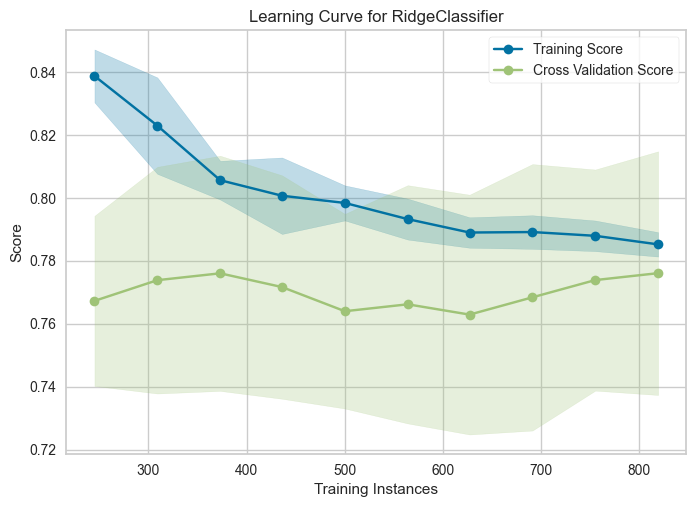

In [31]:
plot_model(best_model, plot = 'learning')

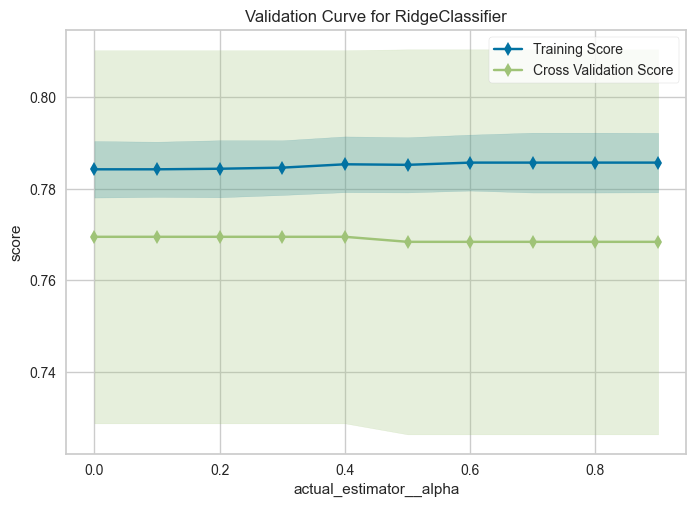

In [32]:
plot_model(best_model, plot = 'vc')

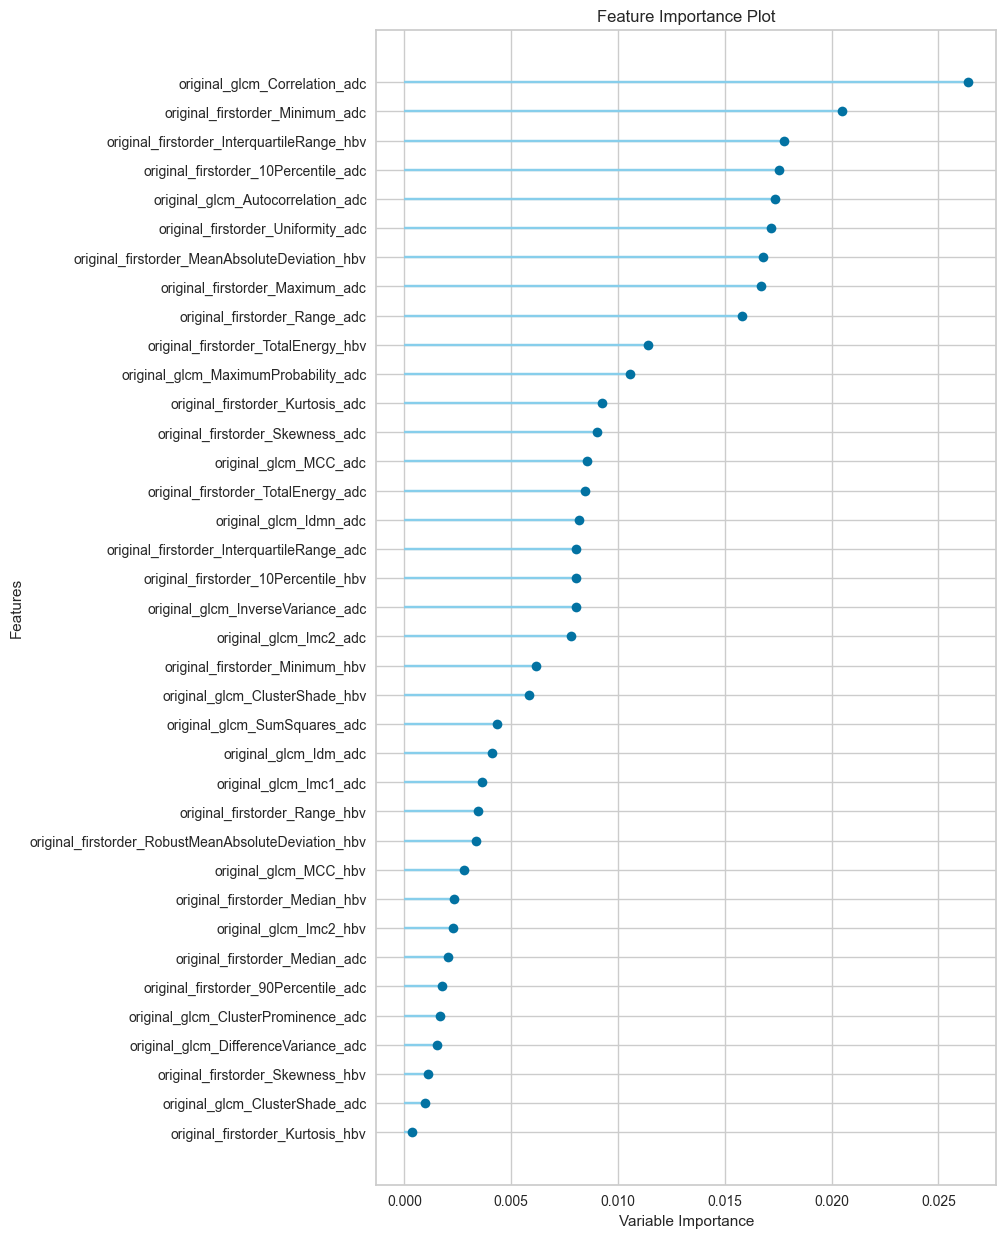

In [33]:
try: 
    plot_model(best_model, plot = 'feature_all')
except:
    print('No feature importance plot available')